In [51]:
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [52]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                                              transforms.ToTensor()#convert image to PyTorch tensor
                                                          ]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([
                                                              transforms.ToTensor()#convert image to PyTorch tensor
                                                          ]))
batch_size = 32

In [53]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)

In [54]:
for data, label in trainloader:
    print(torch.flatten(data,1).shape)
    print(data.shape)
    print(label)
    break

torch.Size([32, 784])
torch.Size([32, 1, 28, 28])
tensor([5, 6, 0, 1, 1, 6, 7, 5, 8, 8, 7, 8, 5, 5, 7, 3, 5, 8, 7, 7, 3, 7, 7, 4,
        1, 4, 7, 7, 7, 2, 8, 4])


In [55]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_derivative(z):
    temp = sigmoid(z)
    return temp * (1.0 - temp)

def softmax(z):
    exps = np.exp(z)
    return exps / np.sum(exps)

def compute_loss(y, y_hat):
    # print(y[0])
    # print(np.log(y_hat)[0])
    # print(-y * np.log(y_hat))
    return -(np.sum(y * np.log(y_hat)))

def forward(x,w1,w2):
    z1 = np.dot(x,w1.T)
    #print(w1.shape,x.T.shape, z1.shape)
    h1 = sigmoid(z1)
    z2 = np.dot(h1,w2.T)
    #print(w2.shape,h1.shape, z2.shape)
    return softmax(z2), h1, z1

def backward(x, y_hat, y, h1, z1, w2):
    dz2 = y_hat - y
    dw1 = []
    dw2 = []
    for i in range(batch_size):
        #print((dz2[i,]).reshape(-1,1).shape,(h1[i,]).reshape(-1,1).shape)
        dw2_temp = np.dot(dz2[i,].reshape(-1,1), (h1[i,]).reshape(-1,1).T)
        #print(dw2_temp)
        #print(dw2_temp.shape)
        #print(dz2[i,].reshape(1,-1).shape,w2.shape)
        dh1 = np.dot(dz2[i,].reshape(1,-1), w2).reshape(-1)
        #print(dh1.shape)
        #print(dh1.shape,h1[i,].shape)
        dz1 = dh1 * sigmoid_derivative(z1[i,])
        #print(dz1)
        #print(x)
        #print(dz1.shape,x[i,].shape)
        dw1_temp = np.outer(dz1,x[i,])
        #print(dw1_temp)
        dw1.append(dw1_temp)
        dw2.append(dw2_temp)
        break
    dw1 = np.array(dw1)
    dw2 = np.array(dw2)
    return dw1, dw2

In [59]:
n_epochs = 10
lr = 0.0001
d = 784
d1 = 300
k = 10
w1 = np.random.uniform(-1, 1, (d1, d))
w2 = np.random.uniform(-1, 1, (k, d1))
# minibatch SGD
for epoch in range(n_epochs):
    loss = 0
    for data, label in trainloader:
        # flattern the data
        data = torch.flatten(data,1)
        # One-hot encode the labels
        categories = [str(i) for i in range(10)]
        encoder = OneHotEncoder(sparse_output=False,categories=[categories])
        y_onehot = encoder.fit_transform(np.array(label).reshape(-1, 1))
        # Forward pass
        y_hat, h1, z1 = forward(data,w1,w2)
        # Compute loss
        loss += compute_loss(y_onehot,y_hat)
        # Backward pass
        dw1, dw2 = backward(data, y_hat, y_onehot, h1, z1, w2)
        # print(dw1.shape,dw2.shape,w1.shape,w2.shape)
        # print(np.sum(dw1,axis = 0).shape)
        w1 = w1 - lr/len(dw1)*np.sum(dw1,axis = 0)
        w2 = w2 - lr/len(dw2)*np.sum(dw2,axis = 0) 
    print("Avg loss for epoch", epoch, "is:", loss/len(trainloader))

Avg loss for epoch 0 is: 431.3250413214755
Avg loss for epoch 1 is: 422.1858082980396
Avg loss for epoch 2 is: 413.00103924225016
Avg loss for epoch 3 is: 404.18042594699324
Avg loss for epoch 4 is: 395.2062644250191
Avg loss for epoch 5 is: 388.51183202695006
Avg loss for epoch 6 is: 385.2095267510393
Avg loss for epoch 7 is: 379.4428730749758
Avg loss for epoch 8 is: 376.26369060775335
Avg loss for epoch 9 is: 377.4769220395761


In [ ]:
#Test
for data, label in testloader:
    # flattern the data
    data = torch.flatten(data,1)
    y_hat, h1, z1 = forward(data,w1,w2)  

In [ ]:
#Q3
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,initial_weight):
        super(FeedForwardNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation= nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)
        if initial_weight == 0:
            init.zeros_(self.fc1.weight)
            init.zeros_(self.fc2.weight)
        elif initial_weight == 'uniform':
            init.uniform_(self.fc1.weight, a=-1, b=1)
            init.uniform_(self.fc2.weight, a=-1, b=1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

# Hyperparameters
input_size = 784
hidden_size = 300
output_size = 10

model = FeedForwardNN(input_size, hidden_size, output_size,None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 20
test_errors = []
epoch_list = []
for epoch in range(num_epochs):
    # Forward pass
    total_loss = 0
    for data, label in trainloader:
        data = torch.flatten(data,1)
        outputs = model(data)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss/len(trainloader)
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    total = 0
    correct = 0
    with torch.no_grad():
        for data, label in testloader:
            data = torch.flatten(data,1)
            outputs = model(data)
            _, predicted = torch.max(outputs.data,1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = 100*correct/total
    test_error = 100-accuracy
    test_errors.append(test_error)
    epoch_list.append(epoch+1)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test error: {test_error:.4f}')

Epoch [1/20], Test error: 26.8600
Epoch [2/20], Test error: 14.6600
Epoch [3/20], Test error: 12.4600
Epoch [4/20], Test error: 11.1700
Epoch [5/20], Test error: 10.5500
Epoch [6/20], Test error: 10.0600
Epoch [7/20], Test error: 9.9900
Epoch [8/20], Test error: 9.6000
Epoch [9/20], Test error: 9.2100
Epoch [10/20], Test error: 9.1300
Epoch [11/20], Test error: 8.9700
Epoch [12/20], Test error: 8.6900
Epoch [13/20], Test error: 8.5100
Epoch [14/20], Test error: 8.3700
Epoch [15/20], Test error: 8.3100
Epoch [16/20], Test error: 8.2200
Epoch [17/20], Test error: 8.1300
Epoch [18/20], Test error: 8.0200
Epoch [19/20], Test error: 8.2900
Epoch [20/20], Test error: 7.9600


Text(0.5, 1.0, 'learning curve for the NN')

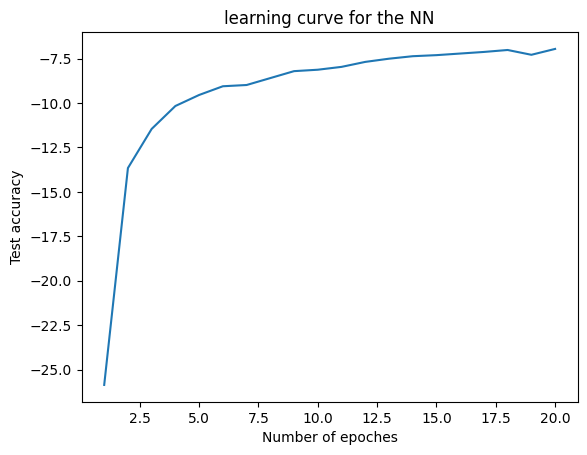

In [ ]:
import pandas as pd
accuracy = [1-x  for x in test_errors]
lc = pd.DataFrame(
    {'epoch': epoch_list,
     'accuracy': accuracy
    })
import matplotlib.pyplot as plt
plt.plot(lc.epoch, lc.accuracy)
plt.xlabel('Number of epoches')
plt.ylabel('Test accuracy')
plt.title('learning curve for the NN')

In [ ]:
#Q4
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,initial_weight):
        super(FeedForwardNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation= nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)
        if initial_weight == 0:
            init.zeros_(self.hidden.weight)
            init.zeros_(self.output.weight)
        elif initial_weight == 'uniform':
            init.uniform_(self.hidden.weight, a=-1, b=1)
            init.uniform_(self.output.weight, a=-1, b=1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

# Hyperparameters
input_size = 784
hidden_size = 300
output_size = 10

model = FeedForwardNN(input_size, hidden_size, output_size,0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 20
test_errors = []
epoch_list = []
for epoch in range(num_epochs):
    # Forward pass
    total_loss = 0
    for data, label in trainloader:
        data = torch.flatten(data,1)
        outputs = model(data)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss/len(trainloader)
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    total = 0
    correct = 0
    with torch.no_grad():
        for data, label in testloader:
            data = torch.flatten(data,1)
            outputs = model(data)
            _, predicted = torch.max(outputs.data,1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = 100*correct/total
    test_error = 100-accuracy
    test_errors.append(test_error)
    epoch_list.append(epoch+1)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test error: {test_error:.4f}')

Epoch [1/20], Test error: 90.2000
Epoch [2/20], Test error: 88.6500
Epoch [3/20], Test error: 89.6800
Epoch [4/20], Test error: 88.6500
Epoch [5/20], Test error: 73.3900
Epoch [6/20], Test error: 66.4900
Epoch [7/20], Test error: 53.2200
Epoch [8/20], Test error: 37.7900
Epoch [9/20], Test error: 28.5700
Epoch [10/20], Test error: 25.0900
Epoch [11/20], Test error: 21.4500
Epoch [12/20], Test error: 17.9600
Epoch [13/20], Test error: 15.9100
Epoch [14/20], Test error: 14.1500
Epoch [15/20], Test error: 12.8900
Epoch [16/20], Test error: 11.9100
Epoch [17/20], Test error: 11.3400
Epoch [18/20], Test error: 11.0100
Epoch [19/20], Test error: 10.6500
Epoch [20/20], Test error: 10.3700


In [ ]:
accuracy = [1-x  for x in test_errors]
lc_zero = pd.DataFrame(
    {'epoch': epoch_list,
     'accuracy': accuracy
    })

Text(0.5, 1.0, 'learning curve for the NN')

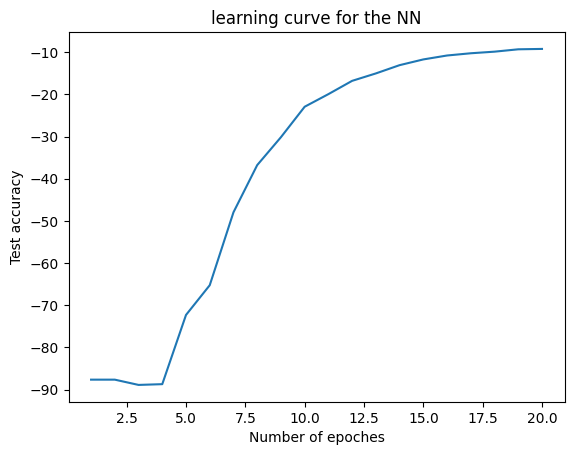

In [ ]:
plt.plot(lc_zero.epoch, lc_zero.accuracy)
plt.xlabel('Number of epoches')
plt.ylabel('Test accuracy')
plt.title('learning curve for the NN')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,initial_weight):
        super(FeedForwardNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation= nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)
        if initial_weight == 0:
            init.zeros_(self.hidden.weight)
            init.zeros_(self.output.weight)
        elif initial_weight == 'uniform':
            init.uniform_(self.hidden.weight, a=-1, b=1)
            init.uniform_(self.output.weight, a=-1, b=1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

# Hyperparameters
input_size = 784
hidden_size = 300
output_size = 10

model = FeedForwardNN(input_size, hidden_size, output_size,'uniform')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 20
test_errors = []
epoch_list = []
for epoch in range(num_epochs):
    # Forward pass
    total_loss = 0
    for data, label in trainloader:
        data = torch.flatten(data,1)
        outputs = model(data)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss/len(trainloader)
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    total = 0
    correct = 0
    with torch.no_grad():
        for data, label in testloader:
            data = torch.flatten(data,1)
            outputs = model(data)
            _, predicted = torch.max(outputs.data,1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = 100*correct/total
    test_error = 100-accuracy
    test_errors.append(test_error)
    epoch_list.append(epoch+1)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test error: {test_error:.4f}')

Epoch [1/20], Test error: 23.7100
Epoch [2/20], Test error: 17.6700
Epoch [3/20], Test error: 15.0700
Epoch [4/20], Test error: 13.6200
Epoch [5/20], Test error: 12.7300
Epoch [6/20], Test error: 11.8700
Epoch [7/20], Test error: 11.2900
Epoch [8/20], Test error: 10.8000
Epoch [9/20], Test error: 10.2800
Epoch [10/20], Test error: 10.0400
Epoch [11/20], Test error: 9.8400
Epoch [12/20], Test error: 9.4900
Epoch [13/20], Test error: 9.3000
Epoch [14/20], Test error: 9.1300
Epoch [15/20], Test error: 8.9400
Epoch [16/20], Test error: 8.7500
Epoch [17/20], Test error: 8.6000
Epoch [18/20], Test error: 8.2700
Epoch [19/20], Test error: 8.2800
Epoch [20/20], Test error: 8.0800


In [ ]:
import pandas as pd
accuracy = [1-x  for x in test_errors]
lc_uniform = pd.DataFrame(
    {'epoch': epoch_list,
     'accuracy': accuracy
    })

Text(0.5, 1.0, 'learning curve for the NN')

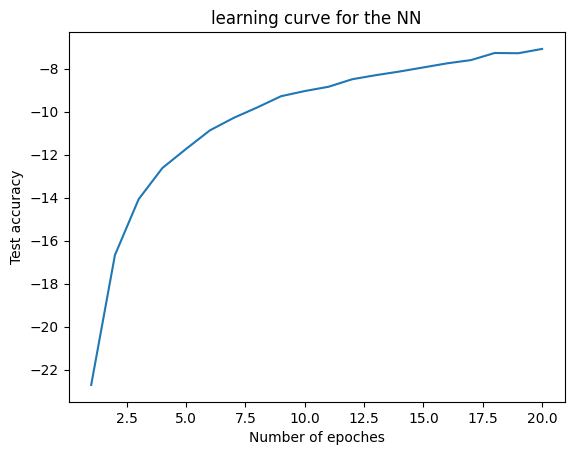

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lc_uniform.epoch, lc_uniform.accuracy)
plt.xlabel('Number of epoches')
plt.ylabel('Test accuracy')
plt.title('learning curve for the NN')